# **Transfer Learning Design Patter**

### ***Loading Libraries***

In [3]:
# Operating Systems
import os
import shutil

# Numerical Computing
import numpy as np

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats

# Data Visualization
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# Scikit-Learn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

# Extreme Gradient Boosting
import xgboost as xgb

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tensorflow_hub import KerasLayer
from tensorflow import feature_column as fc
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

## **Building a Medical Imaging Classification Model with Keras & VGG**

In [4]:
# Data Splitting
(train, validation, test), info = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.5CD2MF_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_dir=PosixGPath('/tmp/tmpqjoqdxomtfds'),
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(150, 150, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, F

In [6]:
# Label's Mapping
label_map = ['tumor','stroma','complex','lympho','debris','mucosa', 'adipose']

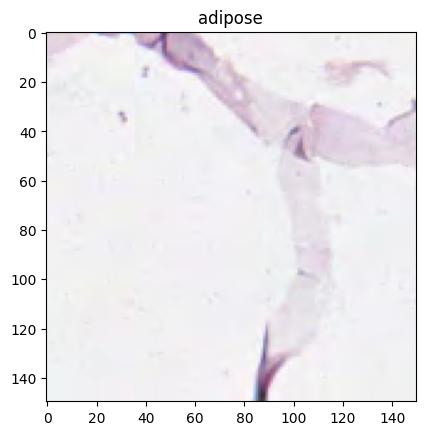

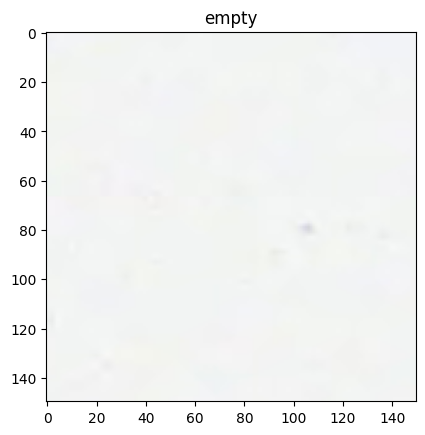

In [7]:
get_label_name = info.features['label'].int2str

for image, label in train.take(2):
  plt.figure()
  plt.imshow(np.array(image))
  plt.title(get_label_name(label))

In [8]:
def label_format(image, label):
  return (image, tf.one_hot(label, depth=8))

train = train.map(label_format)
validation = validation.map(label_format)
test = test.map(label_format)

In [9]:
# Setting Batches
train_batch = train.shuffle(500).batch(32)

val_batch = validation.batch(32)

test_batch = test.batch(32)

In [10]:
for image_batch, label_batch in train_batch.take(1):
   pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [11]:
# Load The VGG Model
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=((150,150,3)),
    classifier_activation='softmax'
)

80134624/80134624 [==============================] - 1s 0us/step


In [12]:
vgg_model.trainable = False

In [13]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
feature_batch = vgg_model(image_batch)

In [15]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)

print(feature_batch_avg.shape)

(32, 512)


In [16]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_avg)

print(prediction_batch.shape)

(32, 8)


In [17]:
# Transfer Learning Procedure
colorectal_model = keras.Sequential([
  vgg_model,
  global_avg_layer,
  prediction_layer
])

In [18]:
colorectal_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 20028488 (76.40 MB)
Trainable params: 4104 (16.03 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [19]:
colorectal_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
colorectal_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - 19s 114ms/step - loss: 2.4139 - accuracy: 0.5570 - val_loss: 1.0532 - val_accuracy: 0.7120
Epoch 2/15
125/125 [==============================] - 12s 92ms/step - loss: 0.9196 - accuracy: 0.7555 - val_loss: 0.7468 - val_accuracy: 0.7660
Epoch 3/15
125/125 [==============================] - 13s 103ms/step - loss: 0.6537 - accuracy: 0.8095 - val_loss: 0.6310 - val_accuracy: 0.7940
Epoch 4/15
125/125 [==============================] - 13s 104ms/step - loss: 0.5146 - accuracy: 0.8390 - val_loss: 0.5496 - val_accuracy: 0.8180
Epoch 5/15
125/125 [==============================] - 13s 95ms/step - loss: 0.4233 - accuracy: 0.8640 - val_loss: 0.5030 - val_accuracy: 0.8180
Epoch 6/15
125/125 [==============================] - 12s 92ms/step - loss: 0.3664 - accuracy: 0.8758 - val_loss: 0.4968 - val_accuracy: 0.8240
Epoch 7/15
125/125 [==============================] - 12s 92ms/step - loss: 0.3217 - accuracy: 0.8960 - val_loss: 0.4770 - val_accuracy: 0.8280


## **Building a Text Classification Model with TF Hub**

In [23]:
# Data Splitting: Train, Test, Validate Procedure
reviews_train, reviews_validate, reviews_test = tfds.load(
    'imdb_reviews',
    split=('train[:80%]', 'train[80%:90%]', 'test'),
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZHHQX4_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZHHQX4_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZHHQX4_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [24]:
for i in reviews_train.take(5):
  print('Review text', i[0].numpy())
  print('Review sentiment', i[1].numpy(), '\n')

Review text b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Review sentiment 0 

Review text b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because t

In [25]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
                           input_shape=[], dtype=tf.string, trainable=True)

In [26]:
test_embedding = hub_layer(["I'm excited to try out transfer learning with TF Hub"])

print(test_embedding)

tf.Tensor(
[[ 0.3780208  -0.8602792   0.47116038  0.8779849  -1.6212035  -0.9306812
  -0.1509569   0.24388756 -0.6550513   0.12114642 -1.3243196   0.7391799
   0.52290976  0.6004199  -1.0018169   0.2770079   1.843374    0.11805204
  -0.18300848 -0.6638955 ]], shape=(1, 20), dtype=float32)


In [27]:
model = keras.Sequential([
  hub_layer,
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_1 (Dense)             (None, 32)                672       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 400725 (1.53 MB)
Trainable params: 400725 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.fit(
    reviews_train.shuffle(10000).batch(512),
    validation_data=reviews_validate.batch(512),
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 11s 195ms/step - loss: 1.0225 - accuracy: 0.4397 - val_loss: 0.7740 - val_accuracy: 0.4996
Epoch 2/15
40/40 [==============================] - 8s 197ms/step - loss: 0.6781 - accuracy: 0.5941 - val_loss: 0.6089 - val_accuracy: 0.6800
Epoch 3/15
40/40 [==============================] - 8s 195ms/step - loss: 0.5703 - accuracy: 0.7041 - val_loss: 0.5436 - val_accuracy: 0.7344
Epoch 4/15
40/40 [==============================] - 7s 176ms/step - loss: 0.5154 - accuracy: 0.7545 - val_loss: 0.4995 - val_accuracy: 0.7648
Epoch 5/15
40/40 [==============================] - 7s 169ms/step - loss: 0.4688 - accuracy: 0.7910 - val_loss: 0.4603 - val_accuracy: 0.7892
Epoch 6/15
40/40 [==============================] - 6s 148ms/step - loss: 0.4245 - accuracy: 0.8200 - val_loss: 0.4292 - val_accuracy: 0.8056
Epoch 7/15
40/40 [==============================] - 5s 117ms/step - loss: 0.3869 - accuracy: 0.8387 - val_loss: 0.3961 - val_accuracy: 0.8268
Epoch 8/15
40/40

In [30]:
# Model Evaluation
results = model.evaluate(reviews_test.batch(512))

49/49 [==============================] - 2s 40ms/step - loss: 0.3108 - accuracy: 0.8672


In [31]:
prediction = model.predict(reviews_test.batch(512))

49/49 [==============================] - 1s 25ms/step


In [32]:
for i,val in enumerate(reviews_test.take(10)):
  print(val[0])
  print(prediction[i][0])
  print()

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
0.15268546

tf.Tensor(